In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import operator
import warnings
warnings.filterwarnings('ignore')
import os
from queue import PriorityQueue
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pickle as pkl
from sacrebleu import raw_corpus_bleu
import math, copy, time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Define constants here
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 32
TEST_BATCH_SIZE = 3
words_to_load = 80000
d_model = emb_size = 300
wiki_size = 300
CUDA = True
MAX_LENGTH = 80
hidden_size = 300

In [3]:
ftdir = '/scratch/yz4499/fasttext/'

In [4]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name, emb_word2id, emb_id2word, emb_ordered_words):
        self.name = name
        self.word2index = emb_word2id
        self.word2count = {}
        self.index2word = emb_id2word #Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#reference: LAB4 hw2
def indexesFromSentences(lang1, lang2, pairs):
    id_list1 = []
    id_list2 = []
    for i in range(len(pairs)):
        sentence1 = pairs[i][0]
        sentence2 = pairs[i][1]
        
        sentence1 = sentence1.replace('quot','')
        sentence1 = sentence1.replace('apos', '')
        sentence2 = sentence2.replace('quot','')
        sentence2 = sentence2.replace('apos', '')
        #If either sentence is empty, then remove the pair
        if sentence1 == '' or sentence2 == '':
            continue;
        
        id_sentence1 = [lang1.word2index[word] if word in lang1.word2index else UNK_TOKEN 
                        for word in sentence1.split()] + [EOS_TOKEN]
        id_list1.append(id_sentence1)
        id_sentence2 = [lang2.word2index[word] if word in lang2.word2index else UNK_TOKEN 
                        for word in sentence2.split()] + [EOS_TOKEN]
        id_list2.append(id_sentence2)
        
   
        
    return id_list1,id_list2

In [5]:
#Reference Lab4 HW2
datadir = os.getcwd()
words_to_load = 50000
# with open(datadir + '/data/wiki-news-300d-1M.vec') as f:
with open(ftdir + 'wiki-news-300d-1M.vec') as f:
    loaded_en_embeddings = np.zeros(((words_to_load+4), wiki_size))
    en_word2id = {}
    en_id2words = {}
    
    en_id2words[PAD_TOKEN] = '<PAD>'
    en_id2words[SOS_TOKEN] = '<SOS>'
    en_id2words[EOS_TOKEN] = '<EOS>'
    en_id2words[UNK_TOKEN] = '<UNK>'
    
    en_word2id['<PAD>'] = PAD_TOKEN
    en_word2id['<SOS>'] = SOS_TOKEN
    en_word2id['<EOS>'] = EOS_TOKEN
    en_word2id['<UNK>'] = UNK_TOKEN
    
    en_ordered_words= []
    en_ordered_words.append('<PAD>')
    en_ordered_words.append('<SOS>')
    en_ordered_words.append('<EOS>')
    en_ordered_words.append('<UNK>')
    
    for i, line in enumerate(f):
        if i >= words_to_load:
            break
        if i ==0:#Ignore the first line
            continue;
        s = line.split()
        #print(len(s))
        loaded_en_embeddings[i+4,:] = np.asarray(s[1:])
        en_word2id[s[0]] = i+4 #for extra pad and unk eos and unk
        en_id2words[i+4] = s[0]
        en_ordered_words.append(s[0])

In [6]:
#Reference Lab4 HW2
#Over 200000 loaded words, 58 has wrong dimensions
words_to_load = 50000
datadir = os.getcwd()
# with open(datadir + '/data/wiki.vi.vec') as f:
with open(ftdir + 'cc.vi.300.vec') as f:
    loaded_vi_embeddings = np.zeros(((words_to_load+4),wiki_size))
    vi_word2id = {}
    vi_id2words = {}
    
    vi_id2words[PAD_TOKEN] = '<PAD>'
    vi_id2words[SOS_TOKEN] = '<SOS>'
    vi_id2words[EOS_TOKEN] = '<EOS>'
    vi_id2words[UNK_TOKEN] = '<UNK>'
    
    vi_word2id['<PAD>'] = PAD_TOKEN
    vi_word2id['<SOS>'] = SOS_TOKEN
    vi_word2id['<EOS>'] = EOS_TOKEN
    vi_word2id['<UNK>'] = UNK_TOKEN
    
    vi_ordered_words= []
    vi_ordered_words.append('<PAD>')
    vi_ordered_words.append('<SOS>')
    vi_ordered_words.append('<EOS>')
    vi_ordered_words.append('<UNK>')
    wrong_dim = 0;
    for i, line in enumerate(f):
        #print(line)
        if i >= words_to_load:
            break;
        if i == 0: #Ignore the first line
            continue;
        s = line.split()
        if len(s) != 301:
            wrong_dim += 1#Skip the wrong dimension one
            continue;
        loaded_vi_embeddings[i+4,:] = np.asarray(s[1:])
        vi_word2id[s[0]] = i+4 #for extra pad and unk 
        vi_id2words[i+4] = s[0]
        vi_ordered_words.append(s[0])
    print('In total {} has wrong dimension, hence skipped'.format(wrong_dim))

In total 0 has wrong dimension, hence skipped


In [7]:
# #loading data
# zh_train_pairs_cleaned = pkl.load(open('./data/zh_train_pairs_cleaned.p', 'rb'))
# zh_val_pairs_cleaned = pkl.load(open('./data/zh_val_pairs_cleaned.p', 'rb'))
# zh_test_pairs_cleaned = pkl.load(open('./data/zh_test_pairs_cleaned.p', 'rb'))

vi_train_pairs_cleaned = pkl.load(open('./data/vi_train_pairs_cleaned.p', 'rb'))
vi_val_pairs_cleaned = pkl.load(open('./data/vi_val_pairs_cleaned.p', 'rb'))
vi_test_pairs_cleaned = pkl.load(open('./data/vi_test_pairs_cleaned.p', 'rb'))

In [8]:
class NMTDataset(Dataset):
    def __init__(self, pairs):#Needs the index pairs
        self.pairs = pairs
#         self.input_lang = input_lang
#         self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
#         padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        padded_seqs = torch.zeros(len(seqs), MAX_LENGTH).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    input_list = torch.from_numpy(np.array(padded_input))
    input_length = torch.LongTensor(input_lens)
    output_list = torch.from_numpy(np.array(padded_output))
    output_length = torch.LongTensor(output_lens)
    
    if CUDA:
        input_list = input_list.cuda()
        output_list = output_list.cuda()
        input_length = input_length.cuda()
        output_length = output_length.cuda()
            
    return [input_list, input_length, output_list, output_length]

In [9]:
BATCH_SIZE = 32
'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned, input_zh, output_zh_en)
# train_vi_dataset = NMTDataset(vi_train_pairs_cleaned, input_vi, output_vi_en)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned, input_zh, output_zh_en)
# val_vi_dataset = NMTDataset(vi_val_pairs_cleaned, input_vi, output_vi_en)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned, input_zh, output_zh_en)
# test_vi_dataset = NMTDataset(vi_test_pairs_cleaned, input_vi, output_vi_en)

# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned)
train_vi_dataset = NMTDataset(vi_train_pairs_cleaned)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned)
val_vi_dataset = NMTDataset(vi_val_pairs_cleaned)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned)
test_vi_dataset = NMTDataset(vi_test_pairs_cleaned)


# train_zh_loader = torch.utils.data.DataLoader(dataset = train_zh_dataset, 
#                                           batch_size = BATCH_SIZE,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = True)

train_vi_loader = torch.utils.data.DataLoader(dataset = train_vi_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)

#Will use batch size 1 for validation and test since the sentence will be translated one by one
# val_zh_loader = torch.utils.data.DataLoader(dataset = val_zh_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
val_vi_loader = torch.utils.data.DataLoader(dataset = val_vi_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# test_zh_loader = torch.utils.data.DataLoader(dataset = test_zh_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
test_vi_loader = torch.utils.data.DataLoader(dataset = test_vi_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
#Input_batch in size Batch x maxLen


In [10]:
for i, (input_list, input_length, output_list, output_length) in enumerate(train_vi_loader):
    if i== 1000:
        break

In [11]:
input_list.size()

torch.Size([32, 80])

In [12]:
#Here for the constant definition
# MAX_SENTENCE_LENGTH = 10
hidden_size = 300
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3
# CLIP = 50
TEACHER_RATIO = 0.5
# EN_ORDERED_NUM = 200003
# ZH_ORDERED_NUM = 199945
# VI_ORDERED_NUM = 199993


In [13]:
class Embeddings(nn.Module):
    def __init__(self, emb, d_model, vocab):
        super(Embeddings, self).__init__()
        self.emb = emb
        self.lut = nn.Embedding.from_pretrained(self.emb, False, False)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [14]:
#Reference: https://stackoverflow.com/questions/52922445/runtimeerror-exp-not-implemented-for-torch-longtensor
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
       
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [15]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [16]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [17]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [18]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [19]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [20]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [21]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [23]:
class SelfEncoder(nn.Module):
    """
    A self attention based Encoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, src_embed):
        super(SelfEncoder, self).__init__()
        self.encoder = encoder
        #self.decoder = decoder
        self.src_embed = src_embed
        #self.tgt_embed = tgt_embed
        #self.generator = generator
        
    def forward(self, src, src_mask=None):
        "Take in and process masked src and target sequences."
        return self.encoder(self.src_embed(src), src_mask)
    

In [24]:
def make_model(emb, src_vocab, N=6, 
               d_model=300, d_ff=2048, h=6, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = SelfEncoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(emb, d_model, src_vocab), c(position)))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [25]:
# #Reference: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
# #Reference: lab8 1_nmt, lab8 3_mri
# class PreAttnDecoderRNN(nn.Module):
#     def __init__(self, emb, emb_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
#         super(PreAttnDecoderRNN, self).__init__()
#         self.emb = emb
#         self.emb_size = emb_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size#vocab size of the output lang
#         self.n_layers = n_layers
#         self.dropout = nn.Dropout(dropout_p)

#         self.embedding = nn.Embedding.from_pretrained(self.emb, False, False,)
        
#         #self.attn = nn.Linear(hidden_size*, hidden_size)
#         #self.attn2 = nn.Linear(hidden_size, hidden_size)
# #         self.v = nn.Parameter(torch.rand(hidden_size))
#         self.concat = nn.Linear(2*hidden_size, hidden_size)
#         self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout = dropout_p)
#         self.out = nn.Linear(hidden_size, output_size)
        
    
#     def forward(self, word_input, last_hidden, encoder_outputs):
#         #Here encoder_outputs is in size batch x max_seq x d_model
#         self.batch_size = encoder_outputs.size(0)
#         max_len = encoder_outputs.size(1)
#         attn_energies = Variable(torch.zeros(self.batch_size, max_len)).to(device)#B X max_len
# #         attn_energies = attn_energies.cuda() if CUDA else attn_energies
        
        
#         embedded = self.embedding(word_input)
#         embedded = self.dropout(embedded)
#         embedded = embedded.view(1, self.batch_size, -1) # S=1 x B x N
        
#         # Get current hidden state from input word and last hidden state
#         rnn_output, hidden = self.gru(embedded, last_hidden)
#         #rnn layer x batch x h
#         #encoder-outputs  max_len x batch x h
        
# #         for b in range(self.batch_size):
# #             # Calculate energy for each encoder output
# #             for i in range(max_len):
# #                 attn_energies[b, i] = (rnn_output[:, b].squeeze()).dot(encoder_outputs[i, b])
        
#         # Calculate attention from current RNN state and all encoder outputs;
#         #More efficient
#         #attn_energies = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(0,1).transpose(1,2))).squeeze(1)
#         attn_energies = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(1,2))).squeeze(1)

#         attn_weights = F.softmax(attn_energies) # B x max_len
#         attn_weights = attn_weights.unsqueeze(1)
#         # apply to encoder outputs to get weighted average
#         context = attn_weights.bmm(encoder_outputs) # B x S=1 x N
        
#         # Attentional vector using the RNN hidden state and context vector

#         # concatenated together (Luong eq. 5)
#         rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
#         context = context.squeeze(1)       # B x S=1 x N -> B x N
#         concat_input = torch.cat((rnn_output, context), 1)
#         concat_output = F.tanh(self.concat(concat_input))

#         # Finally predict next token (Luong eq. 6, without softmax)
#         output = self.out(concat_output)
#         output = F.log_softmax(output)


#         # Return final output, hidden state, and attention weights (for visualization)
#         return output, hidden, attn_weights

In [26]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, embed_size=emb_size):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding.from_pretrained(loaded_vi_embeddings, freeze=False)
        self.attn = nn.Linear(hidden_size + embed_size, self.max_length)
        self.attn_combine = nn.Linear(hidden_size + embed_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_list, hidden, encoder_outputs):
        
        embedded = self.embedding(input_list)
        embedded = self.dropout(embedded)

        concat_input = torch.cat((embedded, hidden), 2)
        attn_weights = F.softmax(self.attn(concat_input), dim=2)
        attn_energies = torch.bmm(attn_weights[0].unsqueeze(1), encoder_outputs).squeeze(1)

        output = torch.cat((embedded[0], attn_energies), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        rnn_output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(rnn_output[0]))
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

### Test for decoder PLS ignore

In [44]:
curr_batch = input_list.size(0)
decoder_input = torch.tensor([[SOS_TOKEN]]*curr_batch, device=device)
    
#decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
decoder_hidden = torch.zeros(attn_decoder.n_layers, curr_batch, attn_decoder.hidden_size)


In [68]:
batch_size = encoder_outputs.size(0)
max_len = encoder_outputs.size(1)
        

In [137]:
attn_energies = Variable(torch.zeros(batch_size, max_len))#B X max_len


In [150]:
attn_weights = F.softmax(attn_energies)

In [153]:
attn_weights = attn_weights.unsqueeze(1)

In [155]:
attn_weights.size(), encoder_outputs.size()

(torch.Size([32, 1, 56]), torch.Size([32, 56, 300]))

In [156]:
context = attn_weights.bmm(encoder_outputs)

In [157]:
context.size()

torch.Size([32, 1, 300])

In [158]:
rnn_output = rnn_output.squeeze(0)

In [159]:
context = context.squeeze(1)  

In [160]:
rnn_output.size()

torch.Size([32, 300])

In [139]:
embedded = loaded_en_embeddings[decoder_input]

embedded = embedded.view(1, batch_size, -1)

In [140]:
embedded.size()

torch.Size([1, 32, 300])

In [142]:
rnn_output, hidden = attn_decoder.gru(embedded, decoder_hidden)

In [143]:
encoder_outputs.size()

torch.Size([32, 56, 300])

In [144]:
for b in range(batch_size):
# Calculate energy for each encoder output
    for i in range(max_len):
        attn_energies[b, i] = (rnn_output[:, b].squeeze()).dot(encoder_outputs[b, i])

In [145]:
temp_test = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(1,2))).squeeze(1)

In [147]:
torch.allclose(temp_test, attn_energies)

True

In [161]:
concat_input = torch.cat((rnn_output, context), 1)

In [162]:
concat_input.size()

torch.Size([32, 600])

In [164]:
concat_output = F.tanh(attn_decoder.concat(concat_input))

In [165]:
concat_output.size()

torch.Size([32, 300])

In [167]:
output = attn_decoder.out(concat_output)
output = F.log_softmax(output)

### End of decode test

In [27]:
# loaded_zh_embeddings = torch.from_numpy(loaded_zh_embeddings).float()
loaded_vi_embeddings = torch.from_numpy(loaded_vi_embeddings).float()
loaded_en_embeddings = torch.from_numpy(loaded_en_embeddings).float()

if CUDA:
#     loaded_zh_embeddings = loaded_zh_embeddings.cuda()
    loaded_vi_embeddings = loaded_vi_embeddings.cuda()
    loaded_en_embeddings = loaded_en_embeddings.cuda()

In [28]:
# #Example of encoder and decoder
# self_encoder = make_model(loaded_vi_embeddings, len(vi_ordered_words)).to(device)
# attn_decoder = AttnDecoderRNN(hidden_size, len(vi_ordered_words)).to(device)

# #SLOW
# learning_rate = 0.01
# encoder_optimizer = optim.Adam(self_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

In [29]:
# encoder_outputs = self_encoder(input_list)
# encoder_outputs.size()

In [30]:
# loss = self_attn_train(input_list, output_list, output_length, self_encoder, attn_decoder, 
#                       encoder_optimizer, decoder_optimizer, criterion)

In [31]:
#Referenced from lab8 1nmt and modified 
def self_attn_train(input_list, output_list,output_length, 
                self_encoder, attn_decoder, encoder_optimizer, decoder_optimizer, criterion):
    '''
    param: @attention is a Boolean variable indicating whether using attention
    '''
    self_encoder.train()
    attn_decoder.train()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
    
    loss = 0

    encoder_outputs = self_encoder(input_list)

    #Initialize for decoding process
#     curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
    #decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
    decoder_outputs = torch.zeros(max_output_length, batch_size, attn_decoder.output_size).to(device)
    
    # Move new Variables to CUDA
#     if CUDA:
#         decoder_input = decoder_input.cuda()
#         decoder_outputs = decoder_outputs.cuda()
    
    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = True
    
    if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = attn_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            decoder_input = output_list[:,di].unsqueeze(0) # Teacher forcing
            loss += criterion(decoder_output, output_list[:,di].contiguous())

    else:
    # Without teacher forcing: use its own predictions as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = attn_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_outputs[di] = decoder_input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)# detach from history as input: size batch x 1 
            loss += criterion(decoder_output, output_list[:,di].contiguous())
            
    #loss += rnn_mask_loss(decoder_outputs.transpose(0,1).contiguous(), output_list.contiguous(), output_length)
            
    loss.backward()
    #ec = torch.nn.utils.clip_grad_norm(batch_encoder.parameters(), CLIP)
    #dc = torch.nn.utils.clip_grad_norm(batch_decoder.parameters(), CLIP)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/max_output_length

In [32]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [35]:
#Reference LAB8 1-nmt
model_path = './model/'
def AttnTrainIters(train_loader, self_encoder, attn_decoder, n_iters, 
                   print_every=100, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(self_encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    epoch = 0
    epoch_total = n_iters*len(train_loader)
    
    for i in range(n_iters):
        #print("Epoch {}/{}".format(i+1, n_epochs))
        for i, (input_list,input_length,output_list, output_length) in enumerate(train_loader):
            loss = self_attn_train(input_list, output_list, output_length, self_encoder, attn_decoder, 
                      encoder_optimizer, decoder_optimizer, criterion)
        
            print_loss_total += loss
            plot_loss_total += loss

            if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / epoch_total),
                                             epoch, epoch / epoch_total * 100, print_loss_avg))

            if i > 0 and i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
            
            epoch += 1
            
        torch.save(self_encoder.state_dict(), model_path + "vi-self_encoder.pth")
        torch.save(attn_decoder.state_dict(), model_path + "vi-self_attn_decoder.pth")

    showPlot(plot_losses)
    return plot_losses

0m 15s (- 518m 28s) (10 0%) 6.1801
0m 28s (- 494m 42s) (20 0%) 2.1405
0m 42s (- 486m 35s) (30 0%) 1.8164
0m 56s (- 482m 13s) (40 0%) 1.9355
1m 9s (- 479m 32s) (50 0%) 1.8489
1m 23s (- 477m 56s) (60 0%) 1.8009
1m 37s (- 476m 41s) (70 0%) 1.8111
1m 50s (- 475m 41s) (80 0%) 1.7441
2m 4s (- 474m 55s) (90 0%) 1.5172
2m 18s (- 474m 26s) (100 0%) 1.4728
2m 32s (- 473m 59s) (110 0%) 1.5191
2m 45s (- 473m 26s) (120 0%) 1.5622
2m 59s (- 472m 58s) (130 0%) 1.4536
3m 13s (- 472m 30s) (140 0%) 1.6161
3m 26s (- 472m 3s) (150 0%) 1.6165
3m 40s (- 471m 37s) (160 0%) 1.5706
3m 54s (- 471m 17s) (170 0%) 1.4338
4m 8s (- 470m 57s) (180 0%) 1.4805
4m 21s (- 470m 35s) (190 0%) 1.5053
4m 35s (- 470m 13s) (200 0%) 1.5523
4m 49s (- 469m 50s) (210 1%) 1.6252
5m 3s (- 469m 32s) (220 1%) 1.4455
5m 16s (- 469m 17s) (230 1%) 1.5545
5m 30s (- 468m 58s) (240 1%) 1.5151
5m 44s (- 468m 38s) (250 1%) 1.4691
5m 57s (- 468m 18s) (260 1%) 1.4140
6m 11s (- 468m 2s) (270 1%) 1.4773
6m 25s (- 467m 44s) (280 1%) 1.5456
6m 39s 

51m 5s (- 424m 40s) (2220 10%) 1.3632
51m 18s (- 424m 25s) (2230 10%) 1.4142
51m 32s (- 424m 11s) (2240 10%) 1.3116
51m 46s (- 423m 56s) (2250 10%) 1.3236
51m 59s (- 423m 41s) (2260 10%) 1.3439
52m 13s (- 423m 26s) (2270 10%) 1.2946
52m 27s (- 423m 12s) (2280 11%) 1.3335
52m 40s (- 422m 57s) (2290 11%) 1.4308
52m 54s (- 422m 42s) (2300 11%) 1.3095
53m 8s (- 422m 28s) (2310 11%) 1.3736
53m 22s (- 422m 13s) (2320 11%) 1.2846
53m 35s (- 421m 59s) (2330 11%) 1.2969
53m 49s (- 421m 44s) (2340 11%) 1.4137
54m 3s (- 421m 31s) (2350 11%) 1.2623
54m 17s (- 421m 18s) (2360 11%) 1.2588
54m 31s (- 421m 5s) (2370 11%) 1.3195
54m 45s (- 420m 51s) (2380 11%) 1.3793
54m 58s (- 420m 38s) (2390 11%) 1.3896
55m 12s (- 420m 25s) (2400 11%) 1.5062
55m 26s (- 420m 11s) (2410 11%) 1.3798
55m 40s (- 419m 58s) (2420 11%) 1.4290
55m 54s (- 419m 45s) (2430 11%) 1.3384
56m 8s (- 419m 32s) (2440 11%) 1.4383
56m 22s (- 419m 18s) (2450 11%) 1.2680
56m 35s (- 419m 5s) (2460 11%) 1.3225
56m 49s (- 418m 52s) (2470 11%)

100m 9s (- 376m 26s) (4345 21%) 1.2235
100m 23s (- 376m 12s) (4355 21%) 1.1786
100m 37s (- 375m 58s) (4365 21%) 1.1739
100m 51s (- 375m 45s) (4375 21%) 1.2166
101m 5s (- 375m 31s) (4385 21%) 1.1190
101m 18s (- 375m 17s) (4395 21%) 1.1456
101m 32s (- 375m 3s) (4405 21%) 1.1867
101m 46s (- 374m 49s) (4415 21%) 1.2930
102m 0s (- 374m 35s) (4425 21%) 1.1638
102m 14s (- 374m 21s) (4435 21%) 1.1949
102m 27s (- 374m 7s) (4445 21%) 1.2372
102m 41s (- 373m 53s) (4455 21%) 1.1441
102m 55s (- 373m 40s) (4465 21%) 1.1612
103m 9s (- 373m 26s) (4475 21%) 1.1855
103m 23s (- 373m 12s) (4485 21%) 1.1919
103m 37s (- 372m 58s) (4495 21%) 1.2077
103m 50s (- 372m 44s) (4505 21%) 1.1595
104m 4s (- 372m 30s) (4515 21%) 1.1929
104m 18s (- 372m 16s) (4525 21%) 1.2069
104m 32s (- 372m 2s) (4535 21%) 1.1965
104m 45s (- 371m 48s) (4545 21%) 1.1912
104m 59s (- 371m 34s) (4555 22%) 1.1707
105m 13s (- 371m 20s) (4565 22%) 1.2100
105m 27s (- 371m 6s) (4575 22%) 1.1935
105m 41s (- 370m 52s) (4585 22%) 1.1141
105m 54s 

147m 48s (- 328m 34s) (6415 31%) 1.0896
148m 2s (- 328m 20s) (6425 31%) 1.0082
148m 16s (- 328m 6s) (6435 31%) 1.1233
148m 30s (- 327m 52s) (6445 31%) 1.1017
148m 43s (- 327m 38s) (6455 31%) 1.0840
148m 57s (- 327m 24s) (6465 31%) 1.1324
149m 11s (- 327m 10s) (6475 31%) 1.0484
149m 25s (- 326m 56s) (6485 31%) 1.0382
149m 39s (- 326m 43s) (6495 31%) 1.1062
149m 52s (- 326m 29s) (6505 31%) 1.0657
150m 6s (- 326m 15s) (6515 31%) 1.1974
150m 20s (- 326m 1s) (6525 31%) 1.1019
150m 34s (- 325m 47s) (6535 31%) 1.1568
150m 48s (- 325m 33s) (6545 31%) 1.0679
151m 1s (- 325m 19s) (6555 31%) 1.1683
151m 15s (- 325m 6s) (6565 31%) 1.0541
151m 29s (- 324m 52s) (6575 31%) 1.0862
151m 43s (- 324m 38s) (6585 31%) 1.1093
151m 57s (- 324m 24s) (6595 31%) 1.0973
152m 10s (- 324m 10s) (6605 31%) 1.0119
152m 24s (- 323m 56s) (6615 31%) 1.1784
152m 38s (- 323m 42s) (6625 32%) 1.0863
152m 52s (- 323m 28s) (6635 32%) 0.9475
153m 6s (- 323m 15s) (6645 32%) 1.0932
153m 19s (- 323m 1s) (6655 32%) 1.1468
153m 33s

195m 33s (- 280m 40s) (8490 41%) 1.0037
195m 47s (- 280m 26s) (8500 41%) 0.9952
196m 1s (- 280m 13s) (8510 41%) 0.9995
196m 15s (- 279m 59s) (8520 41%) 0.9702
196m 29s (- 279m 45s) (8530 41%) 1.0186
196m 43s (- 279m 31s) (8540 41%) 0.9927
196m 56s (- 279m 17s) (8550 41%) 1.0153
197m 10s (- 279m 3s) (8560 41%) 1.0368
197m 24s (- 278m 50s) (8570 41%) 1.0390
197m 38s (- 278m 36s) (8580 41%) 1.0566
197m 52s (- 278m 22s) (8590 41%) 0.9987
198m 5s (- 278m 8s) (8600 41%) 1.0223
198m 19s (- 277m 54s) (8610 41%) 1.0238
198m 33s (- 277m 40s) (8620 41%) 0.9576
198m 47s (- 277m 27s) (8630 41%) 0.9314
199m 1s (- 277m 13s) (8640 41%) 1.0070
199m 14s (- 276m 59s) (8650 41%) 1.0224
199m 28s (- 276m 45s) (8660 41%) 0.9712
199m 42s (- 276m 31s) (8670 41%) 1.0511
199m 56s (- 276m 17s) (8680 41%) 0.9347
200m 10s (- 276m 3s) (8690 42%) 1.0696
200m 23s (- 275m 50s) (8700 42%) 1.0024
200m 37s (- 275m 36s) (8710 42%) 1.0165
200m 51s (- 275m 22s) (8720 42%) 1.0697
201m 5s (- 275m 8s) (8730 42%) 0.9856
201m 19s

242m 55s (- 233m 8s) (10550 51%) 0.9057
243m 9s (- 232m 54s) (10560 51%) 0.8996
243m 23s (- 232m 41s) (10570 51%) 0.9312
243m 37s (- 232m 27s) (10580 51%) 0.9321
243m 51s (- 232m 13s) (10590 51%) 0.9647
244m 4s (- 231m 59s) (10600 51%) 1.0444
244m 18s (- 231m 45s) (10610 51%) 1.0280
244m 32s (- 231m 31s) (10620 51%) 0.9134
244m 46s (- 231m 17s) (10630 51%) 0.9579
244m 59s (- 231m 4s) (10640 51%) 0.9465
245m 13s (- 230m 50s) (10650 51%) 0.9512
245m 27s (- 230m 36s) (10660 51%) 0.9872
245m 41s (- 230m 22s) (10670 51%) 1.0280
245m 55s (- 230m 8s) (10680 51%) 0.9980
246m 8s (- 229m 54s) (10690 51%) 0.9734
246m 22s (- 229m 41s) (10700 51%) 1.0026
246m 36s (- 229m 27s) (10710 51%) 0.9982
246m 50s (- 229m 13s) (10720 51%) 1.0577
247m 4s (- 228m 59s) (10730 51%) 0.9892
247m 17s (- 228m 45s) (10740 51%) 1.0370
247m 31s (- 228m 31s) (10750 51%) 0.9489
247m 45s (- 228m 18s) (10760 52%) 1.0047
247m 59s (- 228m 4s) (10770 52%) 0.9794
248m 13s (- 227m 50s) (10780 52%) 1.0088
248m 26s (- 227m 36s) (1

289m 29s (- 186m 27s) (12575 60%) 0.9419
289m 42s (- 186m 14s) (12585 60%) 0.9371
289m 56s (- 186m 0s) (12595 60%) 0.9084
290m 10s (- 185m 46s) (12605 60%) 0.9234
290m 24s (- 185m 32s) (12615 61%) 0.8913
290m 38s (- 185m 18s) (12625 61%) 0.9254
290m 51s (- 185m 5s) (12635 61%) 1.0265
291m 5s (- 184m 51s) (12645 61%) 0.8459
291m 19s (- 184m 37s) (12655 61%) 0.8899
291m 33s (- 184m 23s) (12665 61%) 0.9207
291m 47s (- 184m 9s) (12675 61%) 0.9233
292m 1s (- 183m 56s) (12685 61%) 0.9144
292m 14s (- 183m 42s) (12695 61%) 0.8948
292m 28s (- 183m 28s) (12705 61%) 0.9201
292m 42s (- 183m 14s) (12715 61%) 0.8955
292m 56s (- 183m 0s) (12725 61%) 0.8396
293m 10s (- 182m 47s) (12735 61%) 0.9376
293m 24s (- 182m 33s) (12745 61%) 0.8477
293m 37s (- 182m 19s) (12755 61%) 0.8952
293m 51s (- 182m 5s) (12765 61%) 0.9660
294m 5s (- 181m 51s) (12775 61%) 0.8940
294m 19s (- 181m 38s) (12785 61%) 0.9024
294m 33s (- 181m 24s) (12795 61%) 0.8943
294m 46s (- 181m 10s) (12805 61%) 0.9079
295m 0s (- 180m 56s) (12

335m 58s (- 139m 57s) (14595 70%) 0.8935
336m 12s (- 139m 43s) (14605 70%) 0.8856
336m 26s (- 139m 30s) (14615 70%) 0.8951
336m 39s (- 139m 16s) (14625 70%) 0.8390
336m 53s (- 139m 2s) (14635 70%) 0.8308
337m 7s (- 138m 48s) (14645 70%) 0.9253
337m 21s (- 138m 34s) (14655 70%) 0.8933
337m 35s (- 138m 20s) (14665 70%) 0.9254
337m 48s (- 138m 7s) (14675 70%) 0.9440
338m 2s (- 137m 53s) (14685 71%) 0.9277
338m 16s (- 137m 39s) (14695 71%) 0.8786
338m 30s (- 137m 25s) (14705 71%) 0.8081
338m 44s (- 137m 11s) (14715 71%) 0.9194
338m 58s (- 136m 58s) (14725 71%) 0.9856
339m 11s (- 136m 44s) (14735 71%) 0.8411
339m 25s (- 136m 30s) (14745 71%) 0.9005
339m 39s (- 136m 16s) (14755 71%) 0.9027
339m 53s (- 136m 2s) (14765 71%) 0.9404
340m 7s (- 135m 49s) (14775 71%) 0.9064
340m 20s (- 135m 35s) (14785 71%) 0.9052
340m 34s (- 135m 21s) (14795 71%) 0.9784
340m 48s (- 135m 7s) (14805 71%) 0.8932
341m 2s (- 134m 53s) (14815 71%) 0.9010
341m 16s (- 134m 39s) (14825 71%) 0.8835
341m 29s (- 134m 26s) (1

382m 49s (- 93m 7s) (16630 80%) 0.8331
383m 3s (- 92m 53s) (16640 80%) 0.8512
383m 17s (- 92m 39s) (16650 80%) 0.8687
383m 31s (- 92m 25s) (16660 80%) 0.9374
383m 45s (- 92m 11s) (16670 80%) 0.8955
383m 58s (- 91m 57s) (16680 80%) 0.8356
384m 12s (- 91m 44s) (16690 80%) 0.8799
384m 26s (- 91m 30s) (16700 80%) 0.8608
384m 40s (- 91m 16s) (16710 80%) 0.8143
384m 54s (- 91m 2s) (16720 80%) 0.8454
385m 7s (- 90m 48s) (16730 80%) 0.8509
385m 21s (- 90m 35s) (16740 80%) 0.9055
385m 35s (- 90m 21s) (16750 81%) 0.7746
385m 49s (- 90m 7s) (16760 81%) 0.8126
386m 3s (- 89m 53s) (16770 81%) 0.8360
386m 17s (- 89m 39s) (16780 81%) 0.8284
386m 30s (- 89m 26s) (16790 81%) 0.8641
386m 44s (- 89m 12s) (16800 81%) 0.8673
386m 58s (- 88m 58s) (16810 81%) 0.8261
387m 12s (- 88m 44s) (16820 81%) 0.8178
387m 26s (- 88m 30s) (16830 81%) 0.8310
387m 39s (- 88m 17s) (16840 81%) 0.8542
387m 53s (- 88m 3s) (16850 81%) 0.8710
388m 7s (- 87m 49s) (16860 81%) 0.8585
388m 21s (- 87m 35s) (16870 81%) 0.8050
388m 35s

430m 29s (- 45m 27s) (18700 90%) 0.8846
430m 43s (- 45m 14s) (18710 90%) 0.8546
430m 57s (- 45m 0s) (18720 90%) 0.7725
431m 10s (- 44m 46s) (18730 90%) 0.8590
431m 24s (- 44m 32s) (18740 90%) 0.8575
431m 38s (- 44m 18s) (18750 90%) 0.8372
431m 52s (- 44m 5s) (18760 90%) 0.8604
432m 6s (- 43m 51s) (18770 90%) 0.8161
432m 19s (- 43m 37s) (18780 90%) 0.8643
432m 33s (- 43m 23s) (18790 90%) 0.8648
432m 47s (- 43m 9s) (18800 90%) 0.8832
433m 1s (- 42m 56s) (18810 90%) 0.7920
433m 14s (- 42m 42s) (18820 91%) 0.8601
433m 28s (- 42m 28s) (18830 91%) 0.8942
433m 42s (- 42m 14s) (18840 91%) 0.8116
433m 56s (- 42m 0s) (18850 91%) 0.8708
434m 10s (- 41m 46s) (18860 91%) 0.8645
434m 23s (- 41m 33s) (18870 91%) 0.8549
434m 37s (- 41m 19s) (18880 91%) 0.8046
434m 51s (- 41m 5s) (18890 91%) 0.8731
435m 5s (- 40m 51s) (18900 91%) 0.8166
435m 19s (- 40m 37s) (18910 91%) 0.8899
435m 32s (- 40m 24s) (18920 91%) 0.8110
435m 46s (- 40m 10s) (18930 91%) 0.8787
436m 0s (- 39m 56s) (18940 91%) 0.8432
436m 14s 

[2.2267380981445317,
 1.5309978647232052,
 1.5039132919311518,
 1.4784453029632567,
 1.464867513656617,
 1.4707394542694092,
 1.418556421279907,
 1.4216064434051519,
 1.4176494274139408,
 1.4037039632797244,
 1.4115832071304317,
 1.4347862081527714,
 1.392030652046204,
 1.4094985542297362,
 1.4140250177383424,
 1.3699999494552617,
 1.3676111764907832,
 1.356375834465027,
 1.3938911361694335,
 1.3529297828674323,
 1.3737692365646357,
 1.3690073575973511,
 1.3608892688751217,
 1.3484640855789187,
 1.371564226150513,
 1.3607674436569217,
 1.3786814928054807,
 1.338022820472717,
 1.3246196937561026,
 1.318066648483277,
 1.2928564739227295,
 1.2917645702362064,
 1.307009921073914,
 1.2724993705749512,
 1.2481625375747678,
 1.2462514991760254,
 1.2544990348815916,
 1.2482392654418943,
 1.2434556112289432,
 1.2099094018936158,
 1.2309175033569335,
 1.6430073003768926,
 1.181596532821655,
 1.1895738086700438,
 1.1883351640701287,
 1.1824496498107913,
 1.1712074890136719,
 1.1562964105606077,
 

<Figure size 432x288 with 0 Axes>

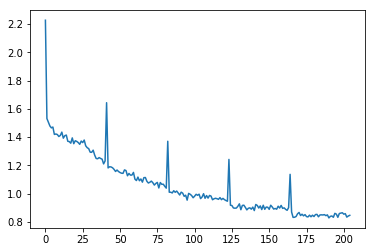

In [37]:
self_encoder = make_model(loaded_vi_embeddings, len(vi_ordered_words)).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, len(vi_ordered_words)).to(device)

AttnTrainIters(train_vi_loader, self_encoder, attn_decoder, 5, print_every=10, plot_every=100, learning_rate=0.001)

In [47]:
# #Reference lab8 1-nmt
# def greedy_selfattn_evaluate(val_loader, encoder, decoder, en_id2words):
#     #Will generate sentences 1 by 1. 
#     # process input sentence
#     decoded_words_all = []
#     decoder_attentions_all = []
    
#     with torch.no_grad():
#         encoder.eval()
#         decoder.eval()
        
#         for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
#             #if i == 5:
#             #    break
#             #batch_size, max_len = output_list.size()
#             #print(input_list.size())
            
#             # encode the source lanugage
#             encoder_outputs = encoder(input_list)

#             decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
#             decoder_hidden = torch.zeros(attn_decoder.n_layers, curr_batch, attn_decoder.hidden_size)

#             # decode the context vector
            
#             # output of this function
#             decoded_words = []
#             decoder_attentions = torch.zeros(100, 100)

#             for di in range(MAX_LENGTH):
#                 # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
#                 decoder_output, decoder_hidden, decoder_attention = decoder(
#                     decoder_input, decoder_hidden, encoder_outputs)

#                 top_score, topi = decoder_output.data.topk(1)
#                 decoder_attentions[di, :decoder_attention.size(-1)] = decoder_attention
#                 decoded_words.append(en_id2words[topi.item()])
#                 if topi.item() == EOS_TOKEN:
#                     break
#                 else:
#                     decoder_input = topi.squeeze().detach()
                    
#             decoded_words_all.append(decoded_words)
#             decoder_attentions_all.append(decoder_attentions[:di+1])

#         return decoded_words_all, decoder_attentions_all

#Reference lab8 1-nmt
def greedy_attn_evaluate(val_loader, encoder, decoder, en_id2words ):
    #Will generate sentences 1 by 1. 
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    decoded_words_all = []
    decoder_attentions_all = []
    
#     batch_size, max_input_length = input_list.size()
#     max_output_length = output_list.size(1)
    
#     loss = 0

#     encoder_outputs = self_encoder(input_list)

#     #Initialize for decoding process
# #     curr_batch = input_list.size(0)#Take the current batch size
#     decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
#     #decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
#     decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
#     decoder_outputs = torch.zeros(max_output_length, batch_size, attn_decoder.output_size).to(device)
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
            if i %100 == 0:
                print("%d/%d"%(i,len(val_loader)))
                
            batch_size, max_input_length = input_list.size()
            max_output_length = output_list.size(1)
            
            #    break
            #batch_size, max_len = output_list.size()
#             print(input_list.size())
            
            encoder_outputs = self_encoder(input_list)

            decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
#             decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
            # decode the context vector
            decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
#             decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
            # output of this function
            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

            for di in range(MAX_LENGTH):
                # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input.reshape(1, batch_size), decoder_hidden, encoder_outputs)

                top_score, topi = decoder_output.data.topk(1)
                decoder_attentions[di, :decoder_attention.size(-1)] = decoder_attention
                decoded_words.append(en_id2words[topi.item()])
                if topi.item() == EOS_TOKEN:
                    break
                else:
                    decoder_input = topi.squeeze().detach().unsqueeze(0)
                    
            decoded_words_all.append(decoded_words)
            decoder_attentions_all.append(decoder_attentions[:di+1])

        return decoded_words_all, decoder_attentions_all

In [41]:
def post_process(decoded_words_all):
    cleaned_decoded_words_all = []
    
    for sentence in decoded_words_all:
        cleaned_sentence = []
        for word in sentence:
            if word == '<PAD>':
                continue
            else:
                cleaned_sentence.append(word)
        if cleaned_sentence[-1] != '<EOS>':
            cleaned_sentence.append(' <EOS>')
            
        cleaned_decoded_words_all.append(cleaned_sentence)
        
    return cleaned_decoded_words_all

#Translate the test and val lists back to english
def en_translate(index_list, en_id2words):
    translated_sentence_list = []
    for sentence in index_list:
        translated_sentence = []
        for index in sentence:
            translated_sentence.append(en_id2words[index])
        #translated_sentence.append('<EOS>')
        translated_sentence_list.append(translated_sentence)
    return translated_sentence_list

In [42]:
vi_en_val_list = [pair[1] for pair in vi_val_pairs_cleaned]
translated_sentence_list = en_translate(vi_en_val_list, en_id2words)
translated_sentence_list[0]

['when',
 'i',
 'was',
 'little',
 'i',
 'thought',
 'my',
 'country',
 'was',
 'the',
 'best',
 'on',
 'the',
 'planet',
 'and',
 'i',
 'grew',
 'up',
 'singing',
 'a',
 'song',
 'called',
 'nothing',
 'to',
 'envy',
 '.',
 '<EOS>']

In [48]:
decoded_val, decoder_attentions = greedy_attn_evaluate(val_vi_loader, self_encoder, attn_decoder, en_id2words)
decoded_clean = post_process(decoded_val)

0/1262
100/1262
200/1262
300/1262
400/1262
500/1262
600/1262
700/1262
800/1262
900/1262
1000/1262
1100/1262
1200/1262


In [49]:
from sacrebleu import corpus_bleu,raw_corpus_bleu

def bleu_score(predicted_list,translated_list):
    predicted_list_nopad = []
    for ii in range(len(predicted_list)):
        line = ''
        for jj in predicted_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        predicted_list_nopad.append(line)
    labels = []
    for ii in range(len(translated_list)):
        line = ''
        for jj in translated_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        labels.append(line)
    #print(len(labels))
    #print(len(predicted_list_nopad))
    print('bleu score for test dataset:', corpus_bleu(predicted_list_nopad, [labels]).score)
    print('bleu score for test dataset [raw]:', raw_corpus_bleu(predicted_list_nopad, [labels]).score)

In [50]:
bleu_score(decoded_clean,translated_sentence_list)

bleu score for test dataset: 15.055388775328003
bleu score for test dataset [raw]: 6.6046179332195605
